In [1]:
import glob, os
from astropy.io import ascii
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import time
from astropy.time import Time

In [2]:
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [3]:
def calc_snr(merr):
	# σ(m) = ±2.5log(1 + N/S)
	return 1/(10**((merr/2.5)-1))

def convert_lam2nu(lam):
	"""
	lam : [AA]
	"""
	from astropy import constants as const
	c = const.c
	#	Return [Hz]
	return c.to(u.Angstrom*u.Hz).value/lam

In [4]:
infotbl = ascii.read('../0.info/info.dat')
infotbl

t0 = Time(infotbl['t0'].item(), format='isot')

In [6]:
infotbl

name,t0,ra,dec,xscale,yscale,color1,color0
str10,str23,float64,float64,str3,str6,str1,str1
GRB221009A,2022-10-09T13:16:59.000,288.26452,19.7735,log,linear,B,R


In [5]:
phtbl = vstack([ascii.read(indat) for indat in sorted(glob.glob('../3.table/phot.*.dat'))])
obsarr = np.unique(phtbl['obs'])
filterarr = np.unique(phtbl['filter'])

print(list(obsarr))
print(list(filterarr))

['BOAO', 'KCT_STX16803', 'LOAO', 'LSGT', 'RASA36', 'SAO_C361K']
['B', 'I', 'J', 'Ks', 'R', 'V', 'g', 'i', 'r', 'y', 'z']


In [53]:
phtbl['delt'] = phtbl['jd']-t0.jd
phtbl = phtbl[np.argsort(phtbl['delt'])]
phtbl['snr'] = calc_snr(phtbl['magerr'])
phtbl['fnu'] = (phtbl['mag']*u.ABmag).to(u.uJy)
phtbl['fnuerr'] = phtbl['fnu']/phtbl['snr']


phtbl['delt'].format = '1.3f'
phtbl['snr'].format = '1.3f'
phtbl['fnu'].format = '1.3f'
phtbl['fnuerr'].format = '1.3f'

phtbl['snr'][phtbl['mag']==-99] = -99
phtbl['fnu'][phtbl['mag']==-99] = -99
phtbl['fnuerr'][phtbl['mag']==-99] = -99

In [54]:
phtbl.write('../3.table/phot.raw.ecsv', format='ascii.ecsv', overwrite=True)

In [55]:
ktbl = phtbl[
	(phtbl['filter']=='Ks')
]
ktbl

image,obs,obj,ra,dec,date-obs,jd,filter,stdnumb,zp,zper,seeing,skyval,skysig,ul_3sig,ul_5sig,mag,magerr,aper_dia_pix,EXPT_total,peeing,aper,delt,snr,fnu,fnuerr
,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy
str75,str12,str10,float64,float64,str23,float64,str2,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
wtrimCalib-BOAO-GRB221009A-20221018-121958-Ks-1260.com_mp.fits,BOAO,GRB221009A,288.2645255,19.7733891,2022-10-18,2459870.5,Ks,8,26.434,0.026,9.93,-1.608,10.971,20.129,19.575,17.707,0.05,11.58,--,--,--,8.447,9.550,300.054,31.420
wtrimCalib-BOAO-GRB221009A-20221019-094213-Ks-840.com_mp.fits,BOAO,GRB221009A,288.2645702,19.7734206,2022-10-19,2459871.5,Ks,7,26.482,0.039,7.57,-1.113,12.229,20.413,19.858,17.87,0.057,8.82,--,--,--,9.447,9.489,258.226,27.214
wtrimCalib-BOAO-GRB221009A-20221020-094343-Ks-1680.com_mp.fits,BOAO,GRB221009A,288.2646043,19.77343,2022-10-20,2459872.5,Ks,7,26.451,0.068,6.045,-1.168,9.819,20.864,20.309,18.128,0.076,7.04,--,--,--,10.447,9.324,203.610,21.837
wtrimCalib-BOAO-GRB221009A-20221022-093933-Ks-1680.com_mp.fits,BOAO,GRB221009A,288.2645963,19.7734023,2022-10-22,2459874.5,Ks,10,26.398,0.084,5.436,-0.639,10.199,20.848,20.293,18.476,0.096,6.34,--,--,--,12.447,9.154,147.775,16.144


In [56]:
filterdict = dict(
	#	Johnson-Cousine (CFHT)
	B=dict(
		lam=4300.82,
		bdw=941.52,
		c='blue',
	),
	V=dict(
		lam=5338.40,
		bdw=909.75,
		c='green',
	),
	R=dict(
		lam=6515.58,
		bdw=1184.89,
		c='red',
	),
	I=dict(
		lam=8091.02,
		bdw=2024.22,
		c='blueviolet',
	),
	#	SDSS (PS1)
	g=dict(
		lam=4810.16,
		bdw=1053.08,
		c='dodgerblue',
	),
	r=dict(
		lam=6155.47,
		bdw=1252.41,
		c='tomato',
	),
	i=dict(
		lam=7503.03,
		bdw=1206.62,
		c='violet'
	),
	z=dict(
		lam=8668.36,
		bdw=997.72,
		c='indigo'
	),
	y=dict(
		lam=9613.60,
		bdw=638.98,
		c='navy'
	),
	#	2MASS
	J=dict(
		lam=12350.00,
		bdw=1624.32,
		c='hotpink',
	),
	H=dict(
		lam=16620.00,
		bdw=2509.40,
		c='pink',
	),
	Ks=dict(
		lam=21590.00,
		bdw=2618.87,
		c='magenta'
	),
)

# Extinction Correction

In [57]:
extbl = ascii.read('../3.table/extinction_calculator.csv')
extbl = extbl[extbl['Refcode of the publications']=="2011ApJ...737..103S"]

for filte in np.unique(phtbl['filter']):
	if filte in ['B', 'V', 'R', 'I']:
		bp = f"Landolt {filte}"
	elif filte in ['u', 'g', 'r', 'i', 'z', 'y']:
		bp = f"PS1 {filte}"
	elif filte == 'Ks':
		bp = f"UKIRT K"
	elif filte in ['J', 'H',]:
		bp = f"UKIRT {filte}"
	print(bp, extbl['The Galactic extinction'][extbl['Bandpass']==bp].item())

Landolt B 5.584
Landolt I 2.318
UKIRT J 1.092
UKIRT K 0.465
Landolt R 3.341
Landolt V 4.223
PS1 g 4.885
PS1 i 2.59
PS1 r 3.498
PS1 y 1.674
PS1 z 2.036


In [58]:
def get_Galactic_extinction(filte, extbl):
	if filte in ['U', 'B', 'V', 'R', 'I']:
		bp = f"Landolt {filte}"
	elif filte in ['u', 'g', 'r', 'i', 'z', 'y']:
		bp = f"PS1 {filte}"
	elif filte == 'Ks':
		bp = f"UKIRT K"
	elif filte in ['J', 'H', 'K']:
		bp = f"UKIRT {filte}"
	return extbl['The Galactic extinction'][extbl['Bandpass']==bp].item()

In [59]:
phtbl['raw_mag'] = phtbl['mag']

for ii, filte in enumerate(phtbl['filter']):
	mag = phtbl['mag'][ii]
	if mag != -99:
		phtbl['mag'][ii] -= get_Galactic_extinction(filte, extbl)
	

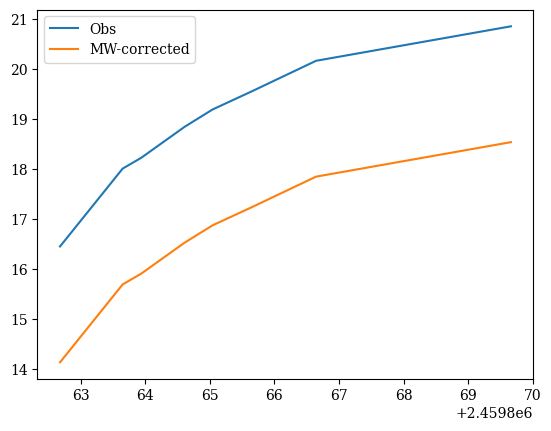

In [60]:
indx_filter = np.where(
	(phtbl['filter']=='I') &
	(phtbl['mag']!=-99)
)
plt.plot(phtbl['jd'][indx_filter], phtbl['raw_mag'][indx_filter], label='Obs')
plt.plot(phtbl['jd'][indx_filter], phtbl['mag'][indx_filter], label='MW-corrected')
plt.legend()

In [61]:
phtbl['fnu'] = (phtbl['mag']*u.ABmag).to(u.uJy)
phtbl['fnuerr'] = phtbl['fnu']/phtbl['snr']

# Light curve

- BOAO

Text(0, 0.5, 'Magnitude [AB]')

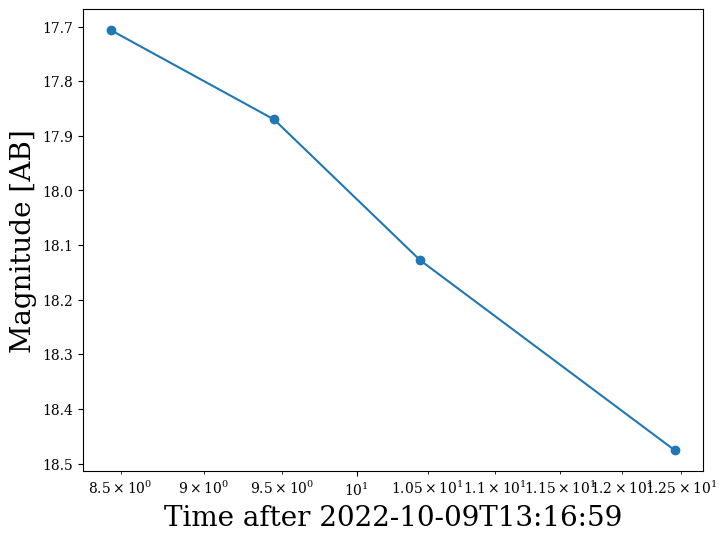

In [62]:
fig = plt.figure(figsize=(8, 6))

plt.plot(ktbl['delt'], ktbl['mag'], marker='o',)
yl, yu = plt.ylim()
plt.ylim([yu, yl])
plt.xscale('log')
plt.xlabel(f'Time after {t0.isot[:-4]}')
plt.ylabel(f'Magnitude [AB]')

- LOAO+BOAO

In [63]:
loaotbl = phtbl[phtbl['obs']=='LOAO']

Text(0, 0.5, 'Magnitude [AB]')

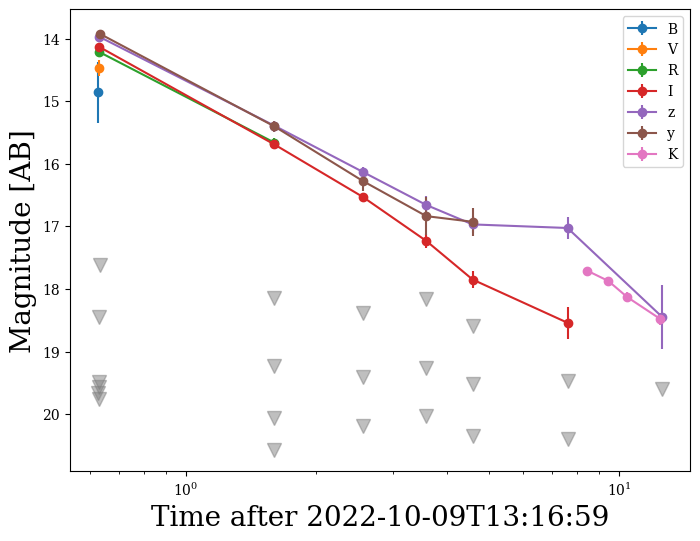

In [64]:
fig = plt.figure(figsize=(8, 6))

for filte in ['B', 'V', 'R', 'I', 'z', 'y']:
	ptbl = loaotbl[(loaotbl['filter']==filte) & (loaotbl['mag']!=-99.0)]
	plt.errorbar(ptbl['delt'], ptbl['mag'], yerr=ptbl['magerr'], marker='o', label=filte)

	ndtbl = loaotbl[(loaotbl['filter']==filte) & (loaotbl['mag']==-99.0)]
	plt.plot(ptbl['delt'], ptbl['ul_5sig'], marker='v', ms=10, ls='none', alpha=0.5, c='grey',)

plt.errorbar(ktbl['delt'], ktbl['mag'], yerr=ktbl['magerr'], marker='o', label='K')

yl, yu = plt.ylim()
plt.legend()
plt.ylim([yu, yl])
plt.xscale('log')
plt.xlabel(f'Time after {t0.isot[:-4]}')
plt.ylabel(f'Magnitude [AB]')

- Others

In [65]:
othtbl = phtbl[
	(phtbl['obs']=='LSGT') |
	(phtbl['obs']=='SAO_C361K') |
	(phtbl['obs']=='RASA36') |
	(phtbl['obs']=='KCT_STX16803')
]

Text(0, 0.5, 'Magnitude [AB]')

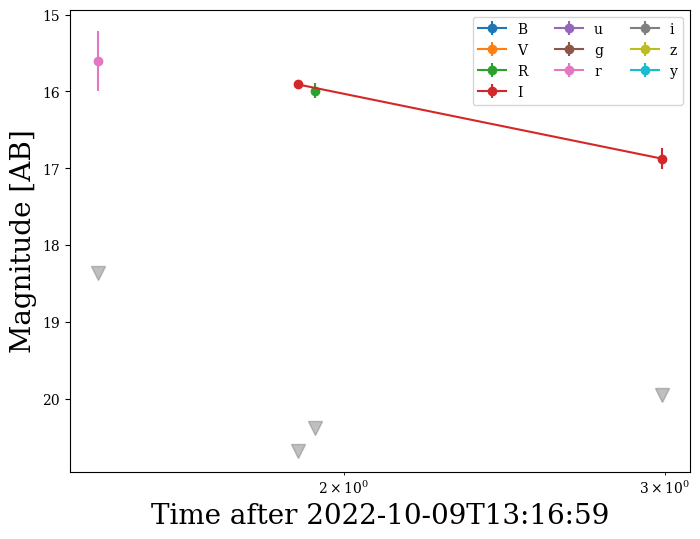

In [66]:
fig = plt.figure(figsize=(8, 6))

for filte in ['B', 'V', 'R', 'I', 'u', 'g', 'r', 'i', 'z', 'y']:
	ptbl = othtbl[(othtbl['filter']==filte) & (othtbl['mag']!=-99.0)]
	plt.errorbar(ptbl['delt'], ptbl['mag'], yerr=ptbl['magerr'], marker='o', label=filte)

	ndtbl = othtbl[(othtbl['filter']==filte) & (othtbl['mag']==-99.0)]
	plt.plot(ptbl['delt'], ptbl['ul_5sig'], marker='v', ms=10, ls='none', alpha=0.5, c='grey',)



# plt.plot(ktbl['delt'], ktbl['mag'], marker='o', label='K')

yl, yu = plt.ylim()
plt.legend(ncol=3)
plt.ylim([yu, yl])
plt.xscale('log')
plt.xlabel(f'Time after {t0.isot[:-4]}')
plt.ylabel(f'Magnitude [AB]')

- no MW extinction correction

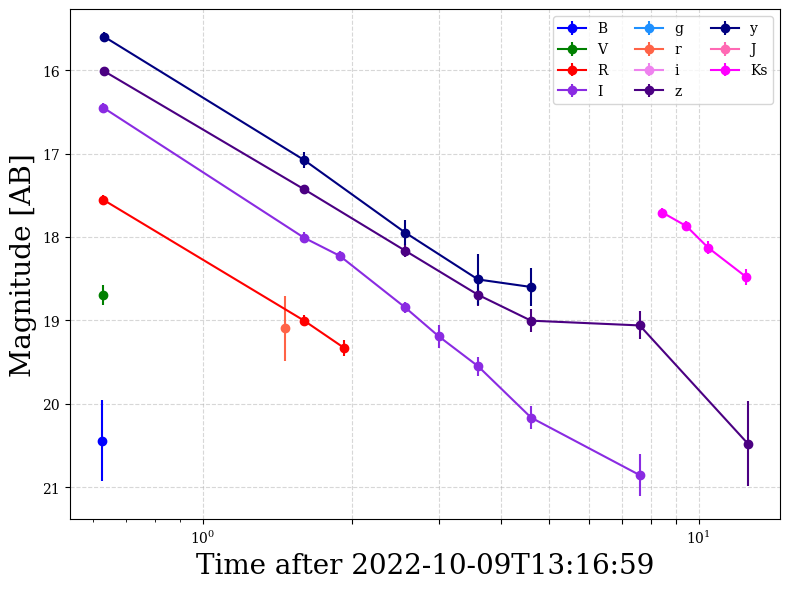

In [67]:
fig = plt.figure(figsize=(8, 6))
filterlist = ['B', 'V', 'R', 'I', 'g', 'r', 'i', 'z', 'y', 'J', 'Ks']
# filterlist = ['R']
for filte in filterlist:
	c = filterdict[filte]['c']
	ptbl = phtbl[(phtbl['filter']==filte) & (phtbl['raw_mag']!=-99.0)]
	plt.errorbar(ptbl['delt'], ptbl['raw_mag'], yerr=ptbl['magerr'], c=c, marker='o', label=filte)

	ndtbl = phtbl[(phtbl['filter']==filte) & (phtbl['raw_mag']==-99.0)]
	# plt.plot(ptbl['delt'], ptbl['ul_5sig'], marker='v', ms=10, ls='none', alpha=0.5, c='grey',)

yl, yu = plt.ylim()
plt.legend(ncol=3)
plt.ylim([yu, yl])
plt.xscale('log')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,])
plt.xlabel(f'Time after {t0.isot[:-4]}')
plt.ylabel(f'Magnitude [AB]')
plt.grid('both', ls='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('../4.plot/lc.linear.png')
# plt.savefig('../4.plot/lc.log.png')

- MW extinction

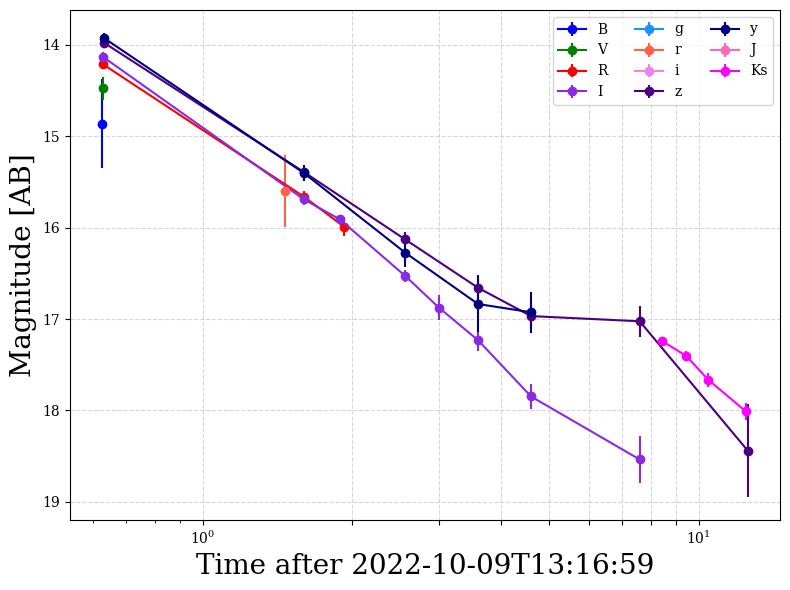

In [68]:
fig = plt.figure(figsize=(8, 6))
filterlist = ['B', 'V', 'R', 'I', 'g', 'r', 'i', 'z', 'y', 'J', 'Ks']
# filterlist = ['R']
for filte in filterlist:
	c = filterdict[filte]['c']
	ptbl = phtbl[(phtbl['filter']==filte) & (phtbl['mag']!=-99.0)]
	plt.errorbar(ptbl['delt'], ptbl['mag'], yerr=ptbl['magerr'], c=c, marker='o', label=filte)

	ndtbl = phtbl[(phtbl['filter']==filte) & (phtbl['mag']==-99.0)]
	# plt.plot(ptbl['delt'], ptbl['ul_5sig'], marker='v', ms=10, ls='none', alpha=0.5, c='grey',)

yl, yu = plt.ylim()
plt.legend(ncol=3)
plt.ylim([yu, yl])
plt.xscale('log')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,])
plt.xlabel(f'Time after {t0.isot[:-4]}')
plt.ylabel(f'Magnitude [AB]')
plt.grid('both', ls='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('../4.plot/lc.linear.png')
# plt.savefig('../4.plot/lc.log.png')

# Power-law fitting

In [69]:
def func(x, a, k):
	return a*(x**-k)

def fit_powerlaw(phtbl, filte):
	xdata = phtbl['delt'][(phtbl['filter']==filte) & (phtbl['mag']!=-99)]
	ydata = phtbl['fnu'][(phtbl['filter']==filte) & (phtbl['mag']!=-99)].value
	sigma = phtbl['fnuerr'][(phtbl['filter']==filte) & (phtbl['mag']!=-99)]
	popt, pcov = curve_fit(func, xdata, ydata, sigma=sigma, absolute_sigma=True)
	perr = np.sqrt(np.diag(pcov))
	a = popt[-1]
	aerr = perr[-1]
	return (xdata, ydata, sigma), (popt, a, aerr)

In [70]:
from scipy.optimize import curve_fit

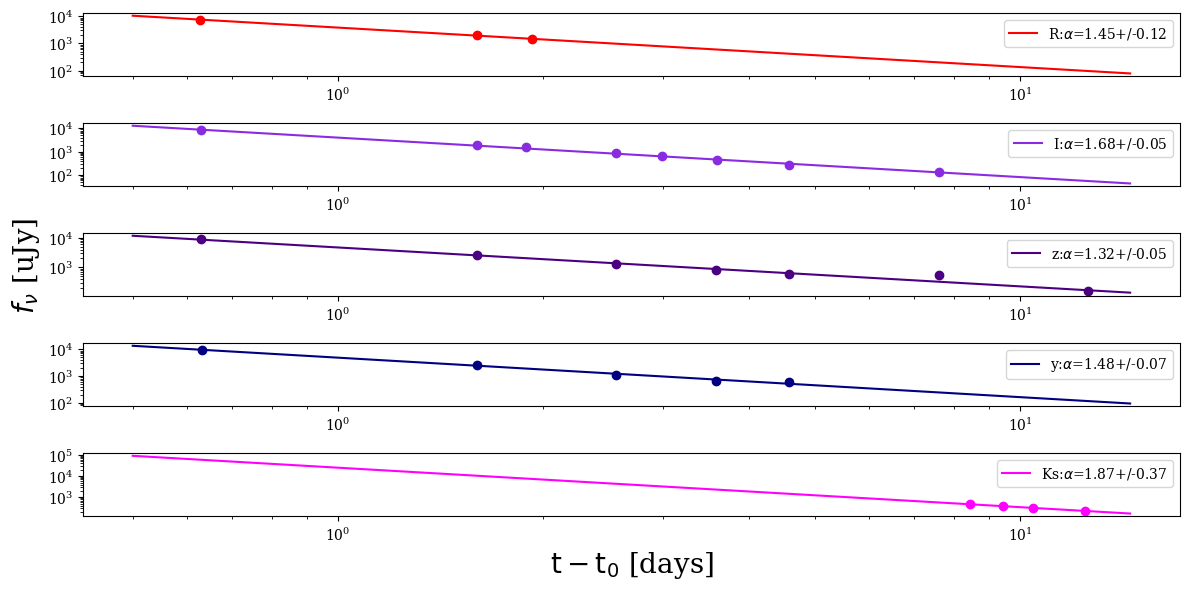

In [71]:
# filterlist = ['B', 'V', 'R', 'I', 'g', 'r', 'i', 'z', 'y', 'J', 'Ks']
filterlist = ['R', 'I', 'z', 'y', 'Ks']
x = np.arange(0.5, 14+1, 1)

fig = plt.figure(figsize=(12, 6))
n = 0
for filte in filterlist:
	if len(phtbl[(phtbl['filter']==filte) & (phtbl['mag']!=-99)]) > 2:
		n+=1
		plt.subplot(len(filterlist), 1, n)
		c = filterdict[filte]['c']
		(xdata, ydata, sigma), (popt, a, aerr) = fit_powerlaw(phtbl, filte=filte)
		plt.errorbar(xdata, ydata, yerr=sigma, c=c, marker='o', ls='none')
		plt.plot(x, func(x, *popt), c=c, label=f"{filte}:"+r'$\alpha$='+f"{a:1.2f}+/-{aerr:1.2f}")

		plt.legend()
		plt.xscale('log')
		plt.yscale('log')
		#	Brute coding
		if n == 3:
			plt.ylabel(r'$f_{\nu}$ [uJy]')
plt.xlabel(r'$\rm t-t_0$ [days]')
plt.tight_layout()
plt.savefig('../4.plot/fit.png')

# SED

In [72]:
def makeSpecColors(n, palette='Spectral'):
	#	Color palette
	import seaborn as sns
	palette = sns.color_palette(palette, as_cmap=True,)
	palette.reversed

	clist_ = [palette(i) for i in range(palette.N)]
	cstep = int(len(clist_)/n)
	clist = [clist_[i*cstep] for i in range(n)]
	return clist

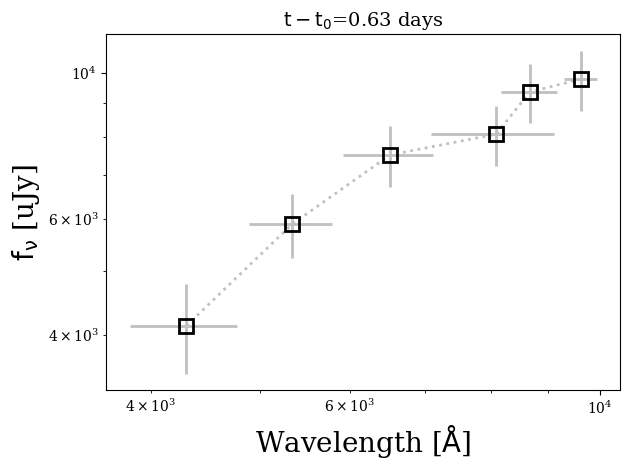

In [73]:
filterlist = ['B', 'V', 'R', 'I', 'z', 'y']

ptbl = loaotbl[(loaotbl['delt']<0.7) & (loaotbl['mag']!=-99)]
delt = np.mean(ptbl['delt'])
fnu = ptbl['fnu']
fnuerr = ptbl['fnuerr']
lam = [filterdict[filte]['lam'] for filte in filterlist]
bdw = [filterdict[filte]['bdw']/2 for filte in filterlist]

plt.title(r"$\rm t-t_0$"+f'={delt:1.2f} days')
plt.errorbar(lam, fnu, xerr=bdw, yerr=fnuerr, marker='s', mfc='none', mec='k', mew=2, ms=10, c='silver', ls=':', lw=2,)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
plt.xlabel(r'Wavelength [$\rm \AA$]')
plt.tight_layout()

In [74]:
ts_zband = np.unique(phtbl['delt'][(phtbl['filter']=='z') & (phtbl['mag']!=-99)])
ts_zband

0.630
1.599
2.558
3.588
4.590
7.605
12.562


0.6303393519483507 ['B', 'V', 'R', 'I', 'z', 'y']
1.5988726848736405 ['r', 'I', 'y', 'z', 'R']
2.5583171295002103 ['I', 'z', 'y']
3.588339351583272 ['z', 'y', 'I']
4.589939351659268 ['z', 'y', 'I']
7.60540601843968 ['z', 'I']
12.561710081063211 ['Ks', 'z']


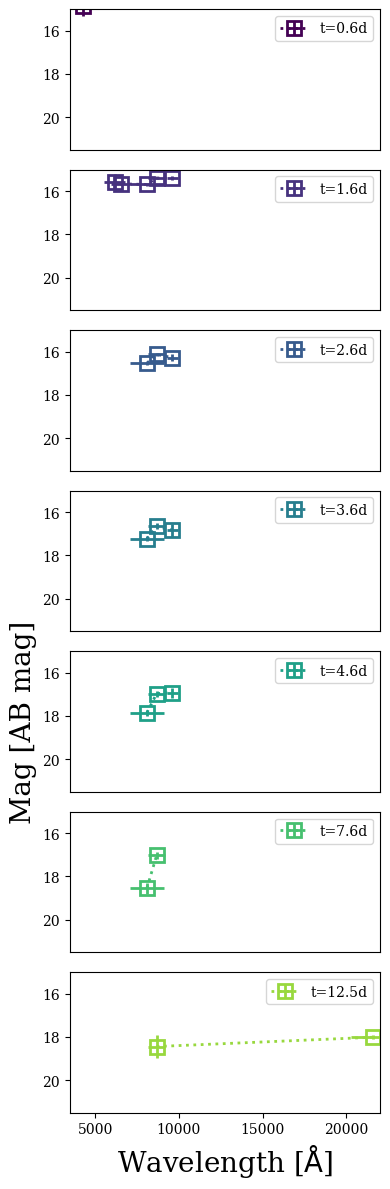

In [75]:
colors = makeSpecColors(len(ts_zband), palette='viridis')
ttol = 0.25
xl, xr = 3500, 22000
yl, yu = 15, 21.5

fig = plt.figure(figsize=(4, 12))
for tt, delt in enumerate(ts_zband):
	plt.subplot(len(colors), 1, tt+1)
	plt.subplots_adjust(wspace=0, hspace=0)
	# ptbl = loaotbl[(loaotbl['delt']<0.7) & (loaotbl['mag']!=-99)]
	if tt != len(colors)-1:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol) &
			(phtbl['delt']<delt+ttol)
		]
	else:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol*4) &
			(phtbl['delt']<delt+ttol*4)
		]

	filterlist = ptbl['filter']
	print(delt, list(filterlist))
	abmag = ptbl['mag']
	abmagerr = ptbl['magerr']
	fnu = ptbl['fnu']
	fnuerr = ptbl['fnuerr']
	lam = np.array([filterdict[filte]['lam'] for filte in filterlist])
	bdw = np.array([filterdict[filte]['bdw']/2 for filte in filterlist])
	deltmean = np.mean(ptbl['delt'])
	# plt.errorbar(lam[np.argsort(lam)], fnu[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=fnuerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={delt:1.1f}d')
	plt.errorbar(lam[np.argsort(lam)], abmag[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=abmagerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={deltmean:1.1f}d')

	# yl, yu = plt.ylim()
	# plt.xlim([3500, 22000])
	plt.xlim([xl, xr])
	plt.ylim([yu, yl])
	
	if tt==4:
		plt.ylabel('Mag [AB mag]')
	if tt==len(colors)-1:
		plt.xlabel(r'Wavelength [$\rm \AA$]')
	else:
		plt.xticks([])
	plt.legend()
plt.tight_layout()

0.6303393519483507 ['B', 'V', 'R', 'I', 'z', 'y']
1.5988726848736405 ['r', 'I', 'y', 'z', 'R']
2.5583171295002103 ['I', 'z', 'y']
3.588339351583272 ['z', 'y', 'I']
4.589939351659268 ['z', 'y', 'I']
7.60540601843968 ['z', 'I']
12.561710081063211 ['Ks', 'z']


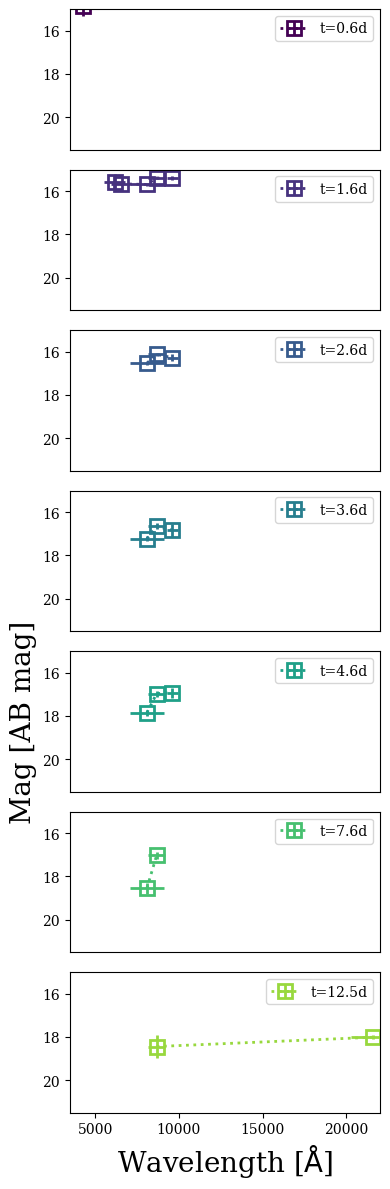

In [76]:
colors = makeSpecColors(len(ts_zband), palette='viridis')
ttol = 0.25
xl, xr = 3500, 22000
yl, yu = 15, 21.5

fig = plt.figure(figsize=(4, 12))
for tt, delt in enumerate(ts_zband):
	plt.subplot(len(colors), 1, tt+1)
	plt.subplots_adjust(wspace=0, hspace=0)
	# ptbl = loaotbl[(loaotbl['delt']<0.7) & (loaotbl['mag']!=-99)]
	if tt != len(colors)-1:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol) &
			(phtbl['delt']<delt+ttol)
		]
	else:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol*4) &
			(phtbl['delt']<delt+ttol*4)
		]

	filterlist = ptbl['filter']
	print(delt, list(filterlist))
	abmag = ptbl['mag']
	abmagerr = ptbl['magerr']
	fnu = ptbl['fnu']
	fnuerr = ptbl['fnuerr']
	lam = np.array([filterdict[filte]['lam'] for filte in filterlist])
	bdw = np.array([filterdict[filte]['bdw']/2 for filte in filterlist])
	deltmean = np.mean(ptbl['delt'])
	# plt.errorbar(lam[np.argsort(lam)], fnu[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=fnuerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={delt:1.1f}d')
	plt.errorbar(lam[np.argsort(lam)], abmag[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=abmagerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={deltmean:1.1f}d')

	# yl, yu = plt.ylim()
	# plt.xlim([3500, 22000])
	plt.xlim([xl, xr])
	plt.ylim([yu, yl])
	
	if tt==4:
		plt.ylabel('Mag [AB mag]')
	if tt==len(colors)-1:
		plt.xlabel(r'Wavelength [$\rm \AA$]')
	else:
		plt.xticks([])
	plt.legend()
plt.tight_layout()

0.6303393519483507 ['B', 'V', 'R', 'I', 'z', 'y']
1.5988726848736405 ['r', 'I', 'y', 'z', 'R']
2.5583171295002103 ['I', 'z', 'y']
3.588339351583272 ['z', 'y', 'I']
4.589939351659268 ['z', 'y', 'I']
7.60540601843968 ['z', 'I']
12.561710081063211 ['Ks', 'z']


delt,filter,lam,bandwidth,mag,magerr,fnu,fnuerr
,,,,,,uJy,uJy
float64,str2,float64,float64,float64,float64,float64,float64
0.629,B,4300.820,470.760,20.444,0.483,24.121,3.764
0.629,V,5338.400,454.875,18.697,0.124,120.559,13.515
0.629,R,6515.580,592.445,17.553,0.053,345.780,36.308
0.629,I,8091.020,1012.110,16.451,0.053,954.113,100.184
0.629,z,8668.360,498.860,16.009,0.042,1433.508,149.005
0.629,y,9613.600,319.490,15.598,0.053,2093.148,219.786
1.572,r,6155.470,626.205,19.096,0.390,83.483,11.956
1.572,I,8091.020,1012.110,18.009,0.066,227.196,24.143


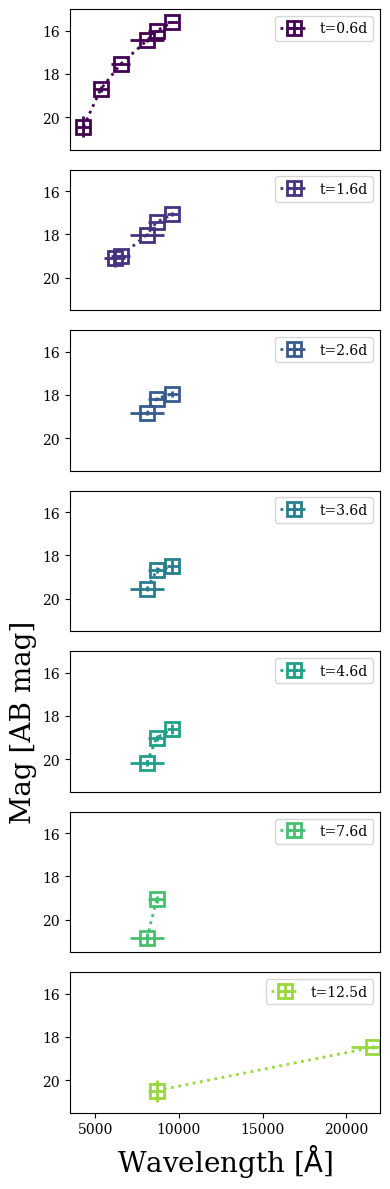

In [84]:
colors = makeSpecColors(len(ts_zband), palette='viridis')
ttol = 0.25
xl, xr = 3500, 22000
yl, yu = 15, 21.5

tablelist = []

fig = plt.figure(figsize=(4, 12))
for tt, delt in enumerate(ts_zband):

	sptbl = Table()

	plt.subplot(len(colors), 1, tt+1)
	plt.subplots_adjust(wspace=0, hspace=0)
	# ptbl = loaotbl[(loaotbl['delt']<0.7) & (loaotbl['mag']!=-99)]
	if tt != len(colors)-1:
		ptbl = phtbl[
			(phtbl['raw_mag']!=-99) &
			(phtbl['delt']>delt-ttol) &
			(phtbl['delt']<delt+ttol)
		]
	else:
		ptbl = phtbl[
			(phtbl['raw_mag']!=-99) &
			(phtbl['delt']>delt-ttol*4) &
			(phtbl['delt']<delt+ttol*4)
		]

	filterlist = ptbl['filter']
	print(delt, list(filterlist))
	abmag = ptbl['raw_mag']
	abmagerr = ptbl['magerr']
	# fnu = ptbl['fnu']
	# fnuerr = ptbl['fnuerr']
	fnu = (ptbl['raw_mag']*u.ABmag).to(u.uJy)
	fnuerr = fnu/ptbl['snr']
	lam = np.array([filterdict[filte]['lam'] for filte in filterlist])
	bdw = np.array([filterdict[filte]['bdw']/2 for filte in filterlist])
	deltmean = np.mean(ptbl['delt'])

	sptbl['delt'] = [deltmean]*len(filterlist)
	sptbl['filter'] = filterlist
	sptbl['lam'] = lam
	sptbl['bandwidth'] = bdw
	sptbl['mag'] = abmag
	sptbl['magerr'] = abmagerr
	sptbl['fnu'] = fnu
	sptbl['fnuerr'] = fnuerr

	#	Plot
	# plt.errorbar(lam[np.argsort(lam)], fnu[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=fnuerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={delt:1.1f}d')
	plt.errorbar(lam[np.argsort(lam)], abmag[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=abmagerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={deltmean:1.1f}d')

	# yl, yu = plt.ylim()
	# plt.xlim([3500, 22000])
	plt.xlim([xl, xr])
	plt.ylim([yu, yl])
	
	if tt==4:
		plt.ylabel('Mag [AB mag]')
	if tt==len(colors)-1:
		plt.xlabel(r'Wavelength [$\rm \AA$]')
	else:
		plt.xticks([])
	plt.legend()

	tablelist.append(sptbl)

plt.tight_layout()

comtbl = vstack(tablelist)
for key in comtbl.keys():
	try:
		comtbl[key].format = '1.3f'
	except:
		pass
comtbl.write('../3.table/sed.raw.ecsv', format='ascii.ecsv', overwrite=True)
comtbl

0.6303393519483507 ['B', 'V', 'R', 'I', 'z', 'y']
1.5988726848736405 ['r', 'I', 'y', 'z', 'R']
2.5583171295002103 ['I', 'z', 'y']
3.588339351583272 ['z', 'y', 'I']
4.589939351659268 ['z', 'y', 'I']
7.60540601843968 ['z', 'I', 'Ks']
12.561710081063211 ['Ks', 'z']


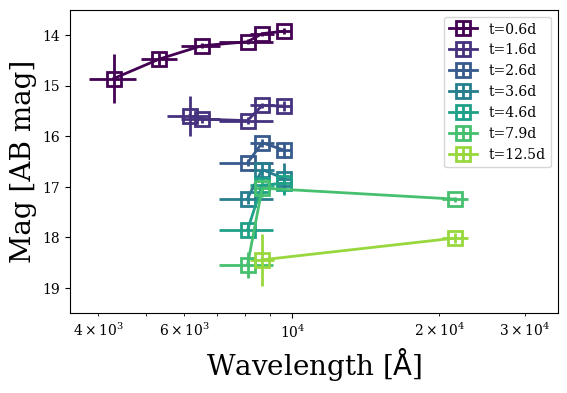

In [72]:
colors = makeSpecColors(len(ts_zband), palette='viridis')
ttol = 0.25
xl, xr = 3500, 35000
yl, yu = 13.5, 19.5

fig = plt.figure(figsize=(6, 4))
for tt, delt in enumerate(ts_zband):
	# plt.subplot(len(colors), 1, tt+1)
	plt.subplot(111)
	plt.subplots_adjust(wspace=0, hspace=0)
	# ptbl = loaotbl[(loaotbl['delt']<0.7) & (loaotbl['mag']!=-99)]
	if tt != len(colors)-2:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol) &
			(phtbl['delt']<delt+ttol)
		]
	else:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol*4) &
			(phtbl['delt']<delt+ttol*4)
		]

	filterlist = ptbl['filter']
	print(delt, list(filterlist))
	abmag = ptbl['mag']
	abmagerr = ptbl['magerr']
	fnu = ptbl['fnu']
	fnuerr = ptbl['fnuerr']
	lam = np.array([filterdict[filte]['lam'] for filte in filterlist])
	bdw = np.array([filterdict[filte]['bdw']/2 for filte in filterlist])
	deltmean = np.mean(ptbl['delt'])
	# plt.errorbar(lam[np.argsort(lam)], fnu[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=fnuerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={delt:1.1f}d')
	plt.errorbar(lam[np.argsort(lam)], abmag[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=abmagerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls='-', lw=2, label=f't={deltmean:1.1f}d')

	# yl, yu = plt.ylim()
	# plt.xlim([3500, 22000])
	plt.xlim([xl, xr])
	plt.ylim([yu, yl])
	
	if tt==4:
		plt.ylabel('Mag [AB mag]')
	if tt==len(colors)-1:
		plt.xlabel(r'Wavelength [$\rm \AA$]')
	else:
		# plt.xticks([])
		pass
	plt.legend()
plt.tight_layout()
plt.xscale('log')
plt.savefig('sed.evolution.abmag.png')

0.6303393519483507 ['B', 'V', 'R', 'I', 'z', 'y']
1.5988726848736405 ['r', 'I', 'y', 'z', 'R']
2.5583171295002103 ['I', 'z', 'y']
3.588339351583272 ['z', 'y', 'I']
4.589939351659268 ['z', 'y', 'I']
7.60540601843968 ['z', 'I']
12.561710081063211 ['Ks', 'z']


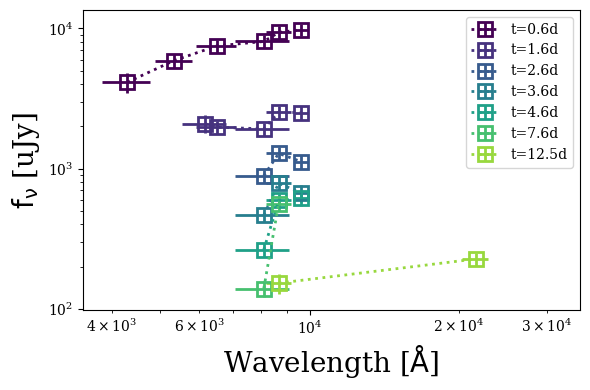

In [73]:
colors = makeSpecColors(len(ts_zband), palette='viridis')
ttol = 0.25
xl, xr = 3500, 35000
# yl, yu

fig = plt.figure(figsize=(6, 4))
for tt, delt in enumerate(ts_zband):
	# plt.subplot(len(colors), 1, tt+1)
	plt.subplot(1,1,1)
	plt.subplots_adjust(wspace=0, hspace=0)
	# ptbl = loaotbl[(loaotbl['delt']<0.7) & (loaotbl['mag']!=-99)]
	if tt != len(colors)-1:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol) &
			(phtbl['delt']<delt+ttol)
		]
	else:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol*4) &
			(phtbl['delt']<delt+ttol*4)
		]

	filterlist = ptbl['filter']
	print(delt, list(filterlist))
	abmag = ptbl['mag']
	abmagerr = ptbl['magerr']
	fnu = ptbl['fnu']
	fnuerr = ptbl['fnuerr']
	lam = np.array([filterdict[filte]['lam'] for filte in filterlist])
	bdw = np.array([filterdict[filte]['bdw']/2 for filte in filterlist])
	deltmean = np.mean(ptbl['delt'])
	# plt.errorbar(lam[np.argsort(lam)], fnu[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=fnuerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={delt:1.1f}d')
	plt.errorbar(lam[np.argsort(lam)], fnu[np.argsort(lam)], xerr=bdw[np.argsort(lam)], yerr=fnuerr[np.argsort(lam)], marker='s', mfc='none', mec=colors[tt], mew=2, ms=10, c=colors[tt], ls=':', lw=2, label=f't={deltmean:1.1f}d')

	# yl, yu = plt.ylim()
	# plt.xlim([3500, 22000])
	plt.xlim([xl, xr])
	# plt.ylim([yu, yl])
	
	if tt==4:
		plt.ylabel(r'$\rm f_{\nu}$ [uJy]')

	if tt==len(colors)-1:
		plt.xlabel(r'Wavelength [$\rm \AA$]')
	else:
		# plt.xticks([])
		pass
	plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('sed.evolution.fnu.png')

In [74]:
def func_linear(lnx, lna, k):
	return lna-k*lnx

0.6303393519483507 ['B', 'V', 'R', 'I', 'z', 'y']
1.5988726848736405 ['r', 'I', 'y', 'z', 'R']
2.5583171295002103 ['I', 'z', 'y']
3.588339351583272 ['z', 'y', 'I']
4.589939351659268 ['z', 'y', 'I']
7.60540601843968 ['z', 'I']
12.561710081063211 ['Ks', 'z']


/Users/paek/opt/miniconda3/envs/kn/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


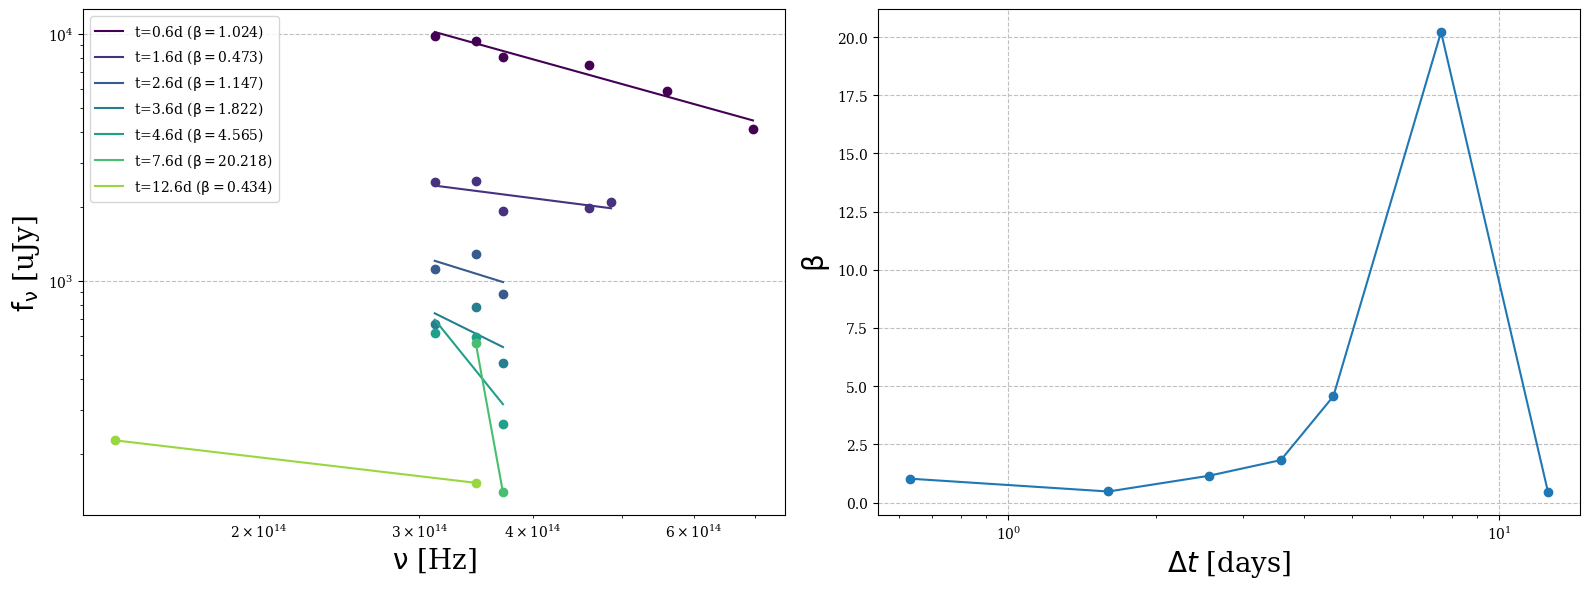

In [75]:
betalist = []

fig = plt.figure(figsize=(16, 6))
for tt, delt in enumerate(ts_zband):
	# plt.subplot(len(colors), 1, tt+1)
	plt.subplot(121)
	plt.subplots_adjust(wspace=0, hspace=0)
	# ptbl = loaotbl[(loaotbl['delt']<0.7) & (loaotbl['mag']!=-99)]
	if tt != len(colors)-1:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol) &
			(phtbl['delt']<delt+ttol)
		]
	else:
		ptbl = phtbl[
			(phtbl['mag']!=-99) &
			(phtbl['delt']>delt-ttol*4) &
			(phtbl['delt']<delt+ttol*4)
		]

	filterlist = ptbl['filter']
	print(delt, list(filterlist))
	abmag = ptbl['mag']
	abmagerr = ptbl['magerr']
	fnu = ptbl['fnu']
	fnuerr = ptbl['fnuerr']
	lam = np.array([filterdict[filte]['lam'] for filte in filterlist])
	nu = convert_lam2nu(lam)
	bdw = np.array([filterdict[filte]['bdw']/2 for filte in filterlist])
	deltmean = np.mean(ptbl['delt'])
	#
	lnx = np.log(nu[np.argsort(nu)])
	lny = np.log(fnu[np.argsort(nu)])
	popt, pcov = curve_fit(func_linear, lnx, lny)
	betalist.append(popt[-1])
	plt.plot(np.exp(lnx), np.exp(lny), 'o', c=colors[tt])
	plt.plot(np.exp(lnx), np.exp(func_linear(lnx, *popt)), label=f"t={delt:1.1f}d "+r"($\rm \beta=$"+f"{popt[-1]:1.3f})", c=colors[tt])

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\rm \nu$ [Hz]')
plt.ylabel(r'$\rm f_{\nu}$'+' [uJy]')
plt.tight_layout()
plt.grid('both', ls='--', c='silver')


plt.subplot(122)
plt.plot(ts_zband, betalist, 'o-')
plt.xlabel(r'$\Delta t$ [days]')
plt.ylabel(r'$\rm \beta$')
plt.xscale('log')
plt.grid('both', ls='--', c='silver')
plt.tight_layout()


# Distance Scaling

In [76]:
from astropy.cosmology import WMAP9 as cosmo
z = 0.151
cdist = cosmo.comoving_distance(z)
ldist = cosmo.luminosity_distance(z)

print(f"redshift            : {z}")
print(f"Comoving Distance   : {cdist:1.1f}")
print(f"Luminosity Distance : {ldist:1.1f}")

redshift            : 0.151
Comoving Distance   : 631.2 Mpc
Luminosity Distance : 726.5 Mpc


In [77]:
def convert_app2abs(m, dist):
	#	Distance [Mpc]
	return m - (5*np.log10(dist)-5)

In [78]:
#	Galactic distance array
ndistarr = 10**np.arange(0, 3+1, 1)*u.kpc
ndistarr
# convert_app2abs(14, ldist.to(u.pc).value)
convert_app2abs(14, ndistarr.to(u.pc).value)

array([  4.,  -1.,  -6., -11.])

In [79]:
Rtbl = phtbl[
	(phtbl['filter']=='R') &
	(phtbl['mag']!=-99)
]
Rtbl

image,obs,obj,ra,dec,date-obs,jd,filter,stdnumb,zp,zper,seeing,skyval,skysig,ul_3sig,ul_5sig,mag,magerr,aper_dia_pix,EXPT_total,peeing,aper,delt,snr,fnu,fnuerr,raw_mag
,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,
str75,str12,str10,float64,float64,str23,float64,str2,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
hdCalib-LOAO-GRB221009A-20221010-042204-R-300.com.fits,LOAO,GRB221009A,288.2646491,19.7733958,2022-10-10T04:22:04.800,2459862.682,R,932,26.948,0.046,2.508,4989.39,36.315,20.303,19.749,14.212,0.053,4.71,--,--,--,0.6285393517464399,9.523574861919197,7502.3962790746145,787.7710195856775,17.553
hdCalib-LOAO-GRB221009A-20221011-033921-R-720.com.fits,LOAO,GRB221009A,288.2647566,19.7734285,2022-10-11T03:39:21.600,2459863.652333333,R,1646,27.78,0.05,2.476,5652.8,38.795,21.131,20.576,15.661999999999999,0.067,4.43,--,--,--,1.5988726848736405,9.401561688035697,1973.3312795364973,209.89398836235182,19.003
Calib-SAO_C361K-GRB221009A-20221011-113238-R-840.com.fits,SAO_C361K,GRB221009A,288.2646013,19.7734156,2022-10-11T11:32:38.400,2459863.981,R,687,26.196,0.024,1.544,1165.47,6.303,20.93,20.375,15.991,0.096,7.63,--,--,--,1.927539351861924,9.153770083623522,1457.4712612565254,159.22087270511662,19.332


In [80]:
kantbl = ascii.read('../3.table/ref.phot.Kann+10.dat')
#	Detection Kann+10
dktbl = kantbl[kantbl['ndflag']!='>']
grbarr = np.unique(dktbl['name'])
print(f"GRB samples (Kann+10): {len(grbarr)}")

GRB samples (Kann+10): 39


(0.0001, 100.0)

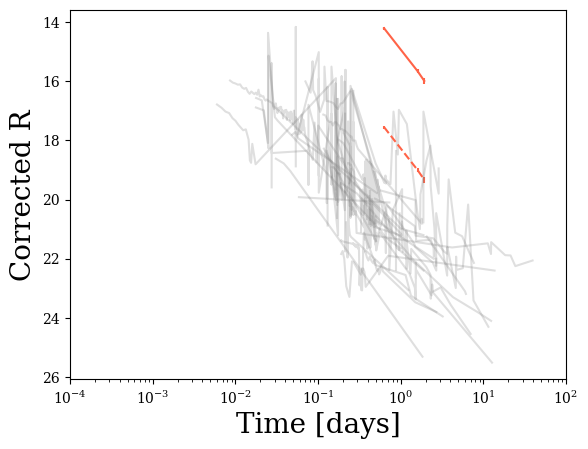

In [96]:
plt.errorbar(Rtbl['delt'], Rtbl['mag'], yerr=Rtbl['magerr'], c='tomato')
plt.errorbar(Rtbl['delt'], Rtbl['raw_mag'], yerr=Rtbl['magerr'], ls='--', c='tomato')

for grb in grbarr:
	grbtbl = dktbl[dktbl['name']==grb]
	grbtbl = grbtbl[np.argsort(grbtbl['t'])]
	plt.plot(grbtbl['t'], grbtbl['mag'], c='grey', alpha=0.25)

plt.xlabel('Time [days]')
plt.ylabel('Corrected R')
plt.xscale('log')
yl, yu = plt.ylim()
plt.ylim([yu, yl])
plt.xlim([1e-4, 1e2])

# Host galaxy extinction correction

In [82]:
ptbl = phtbl[phtbl['delt']<0.7]
# ptbl = phtbl[
# 	(phtbl['delt']>1.5) &
# 	(phtbl['delt']<1.7)
# ]

filterlist = ptbl['filter']
abmag = ptbl['mag']
abmagerr = ptbl['magerr']
fnu = ptbl['fnu']
fnuerr = ptbl['fnuerr']
lam = np.array([filterdict[filte]['lam'] for filte in filterlist])
bdw = np.array([filterdict[filte]['bdw']/2 for filte in filterlist])

Text(0, 0.5, '$\\rm f_{\\nu}$ [uJy]')

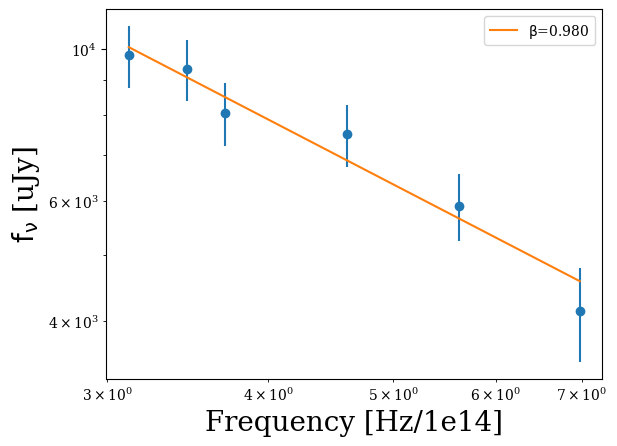

In [83]:
nu = convert_lam2nu(lam)
xdata, ydata, sigma = nu[np.argsort(nu)]/1e14, fnu.value[np.argsort(nu)], fnuerr.value[np.argsort(nu)]
popt, pcov = curve_fit(func, xdata, ydata, sigma=sigma, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
popt
beta0 = popt[-1]
beta0err = perr[-1]

plt.errorbar(xdata, ydata, yerr=sigma, ls='none', marker='o')
plt.errorbar(xdata, func(xdata, *popt), label=r'$\rm \beta$='+f"{beta0:1.3f}")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency [Hz/1e14]')
plt.ylabel(r'$\rm f_{\nu}$ [uJy]')

In [84]:
def func_extc_MW(nu0, beta, Av):
	mdl = 'MW'
	#	Downscale the freq
	# nu0 = nu0/1e15
	nu0 = nu0
	#	Read extinction table
	extbl = ascii.read('../3.table/extinction_law_Pei+92_modification.csv')
	#	Interpolation
	nuext = extbl[f'nu_{mdl}']
	etaext = extbl[f'eta_{mdl}']
	##	Get eta value
	eta = np.interp(nu0, nuext, etaext)
	#	Fix F0
	# nustd = 5*1e14
	# fnustd = np.interp(nustd, xdata, ydata)
	global fnustd

	tau = Av*eta/1.086
	return fnustd*nu0**(-beta)*np.exp(-tau)

Text(0.5, 0, 'Frequency [Hz]')

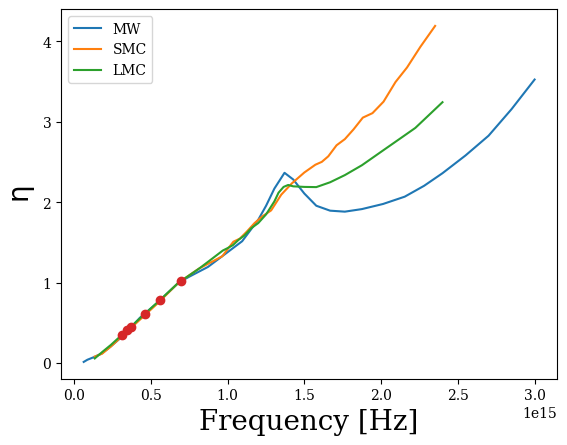

In [85]:
extbl = ascii.read('../3.table/extinction_law_Pei+92_modification.csv')
mdl = 'MW'
models = ['MW', 'SMC', 'LMC']
for mdl in models:
	nuext = extbl[f'nu_{mdl}']
	etaext = extbl[f'eta_{mdl}']
	eta = np.interp(nu[np.argsort(nu)], nuext, etaext)
	plt.plot(nuext, etaext, label=mdl)
plt.plot(nu[np.argsort(nu)], eta, ls='none', marker='o')

plt.legend()
plt.ylabel(r'$\rm \eta$')
plt.xlabel('Frequency [Hz]')


Text(0, 0.5, '$\\rm f_{\\nu}$ [uJy]')

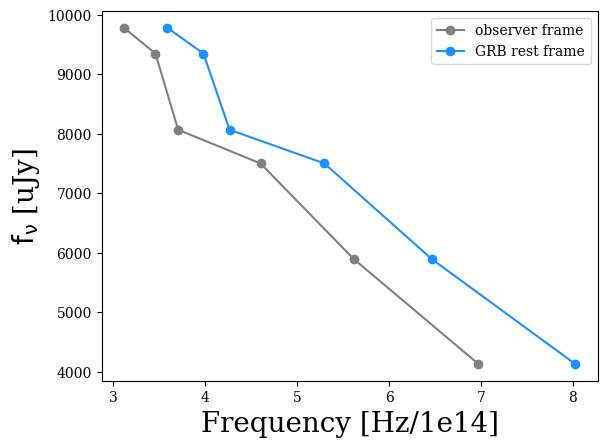

In [86]:
scale = 1e14

#	Fitting
xdata = nu[np.argsort(nu)]*(1+z)/scale
ydata = fnu[np.argsort(nu)]
sigma = fnuerr[np.argsort(nu)]

plt.plot(nu[np.argsort(nu)]/scale, ydata, marker='o', ls='-', c='grey', label='observer frame')
plt.plot(xdata, ydata, marker='o', ls='-', c='dodgerblue', label='GRB rest frame')

plt.legend()
plt.xlabel('Frequency [Hz/1e14]')
plt.ylabel(r'$\rm f_{\nu}$'+f' [uJy]')

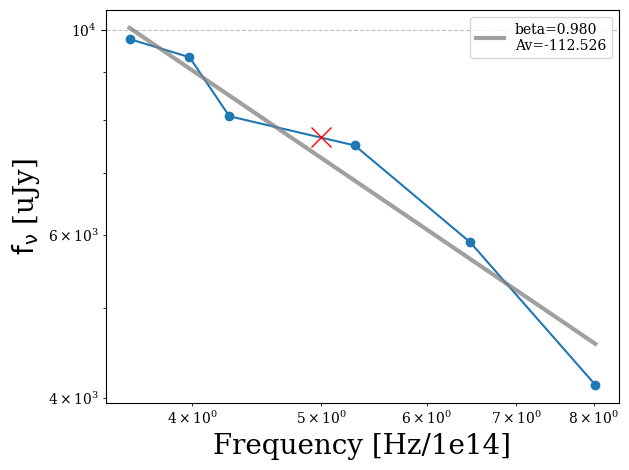

In [87]:
nustd = 5*1e14/scale
fnustd = np.interp(nustd, xdata, ydata)

plt.plot(xdata, ydata, marker='o', ls='-')
plt.plot(nustd, fnustd, marker='x', c='red', ms=14)


guess = (0.980, 0.15)
# func_extc_MW(nu0, F0, beta, Av)
popt, pcov = curve_fit(func_extc_MW, xdata, ydata, sigma=sigma, absolute_sigma=True, p0=guess)
# popt, pcov = curve_fit(func_extc_MW, xdata, ydata,)
#	F0, beta, Av
# popt

plt.plot(xdata, func_extc_MW(xdata, *popt), c='grey', lw=3, alpha=0.75, label=f"beta={popt[0]:1.3f}\nAv={popt[1]:1.3f}")
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Frequency [Hz/1e14]')
plt.ylabel(r'$\rm f_{\nu}$'+' [uJy]')
plt.legend()
plt.tight_layout()
plt.grid('both', ls='--', c='silver')

- Another trial

In [97]:
# def func_extc_MW_linear(lnnu, lnF0, beta, Av):
# 	mdl = 'MW'
# 	#	Read extinction table
# 	extbl = ascii.read('../3.table/extinction_law_Pei+92_modification.csv')
# 	#	Interpolation
# 	nuext = extbl[f'nu_{mdl}']
# 	etaext = extbl[f'eta_{mdl}']
# 	##	Get eta value
# 	eta = np.interp(np.exp(lnnu), nuext, etaext)

# 	return lnF0-(beta*lnnu)-(eta*Av/1.086)

# def func_extc_SMC_linear(lnnu, lnF0, beta, Av):
# 	mdl = 'SMC'
# 	#	Read extinction table
# 	extbl = ascii.read('../3.table/extinction_law_Pei+92_modification.csv')
# 	#	Interpolation
# 	nuext = extbl[f'nu_{mdl}']
# 	etaext = extbl[f'eta_{mdl}']
# 	##	Get eta value
# 	eta = np.interp(np.exp(lnnu), nuext, etaext)

# 	return lnF0-(beta*lnnu)-(eta*Av/1.086)

# def func_extc_LMC_linear(lnnu, lnF0, beta, Av):
# 	mdl = 'LMC'
# 	#	Read extinction table
# 	extbl = ascii.read('../3.table/extinction_law_Pei+92_modification.csv')
# 	#	Interpolation
# 	nuext = extbl[f'nu_{mdl}']
# 	etaext = extbl[f'eta_{mdl}']
# 	##	Get eta value
# 	eta = np.interp(np.exp(lnnu), nuext, etaext)

# 	return lnF0-(beta*lnnu)-(eta*Av/1.086)

In [102]:
def func_extc_MW_linear(lnnu, lnF0, beta):
	mdl = 'MW'
	#	Read extinction table
	extbl = ascii.read('../3.table/extinction_law_Pei+92_modification.csv')
	#	Interpolation
	nuext = extbl[f'nu_{mdl}']
	etaext = extbl[f'eta_{mdl}']
	##	Get eta value
	eta = np.interp(np.exp(lnnu), nuext, etaext)
	#	Fixed Av (Li+18)
	Av = 0.15
	return lnF0-(beta*lnnu)-(eta*Av/1.086)

def func_extc_SMC_linear(lnnu, lnF0, beta):
	mdl = 'SMC'
	#	Read extinction table
	extbl = ascii.read('../3.table/extinction_law_Pei+92_modification.csv')
	#	Interpolation
	nuext = extbl[f'nu_{mdl}']
	etaext = extbl[f'eta_{mdl}']
	##	Get eta value
	eta = np.interp(np.exp(lnnu), nuext, etaext)
	#	Fixed Av (Li+18)
	Av = 0.15
	return lnF0-(beta*lnnu)-(eta*Av/1.086)

def func_extc_LMC_linear(lnnu, lnF0, beta):
	mdl = 'LMC'
	#	Read extinction table
	extbl = ascii.read('../3.table/extinction_law_Pei+92_modification.csv')
	#	Interpolation
	nuext = extbl[f'nu_{mdl}']
	etaext = extbl[f'eta_{mdl}']
	##	Get eta value
	eta = np.interp(np.exp(lnnu), nuext, etaext)
	#	Fixed Av (Li+18)
	Av = 0.15
	return lnF0-(beta*lnnu)-(eta*Av/1.086)

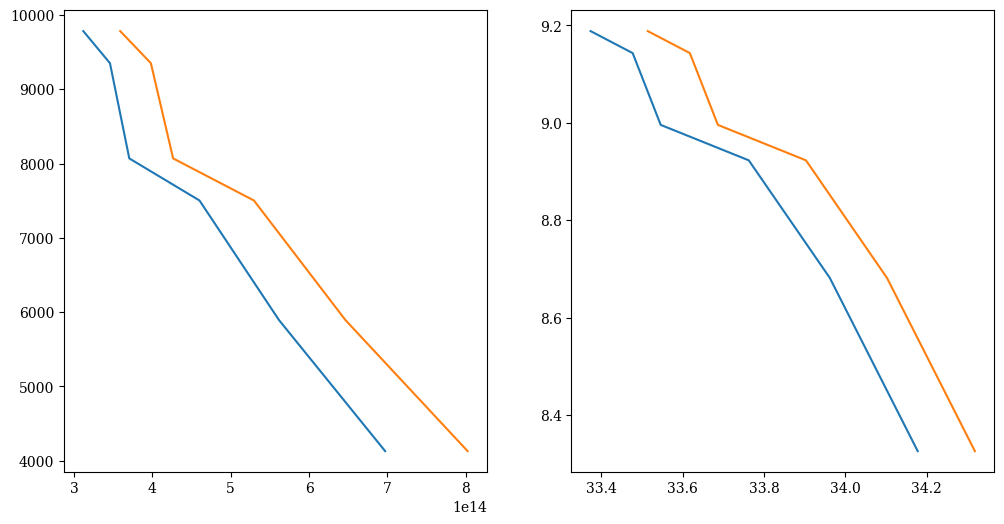

In [103]:
# nu[indx_sort]*(1+z), fnu[indx_sort]
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
indx_sort = np.argsort(nu)
plt.plot(nu[indx_sort], fnu[indx_sort])
plt.plot(nu[indx_sort]*(1+z), fnu[indx_sort])
plt.subplot(122)
plt.plot(np.log(nu[indx_sort]), np.log(fnu[indx_sort]))
plt.plot(np.log(nu[indx_sort]*(1+z)), np.log(fnu[indx_sort]))


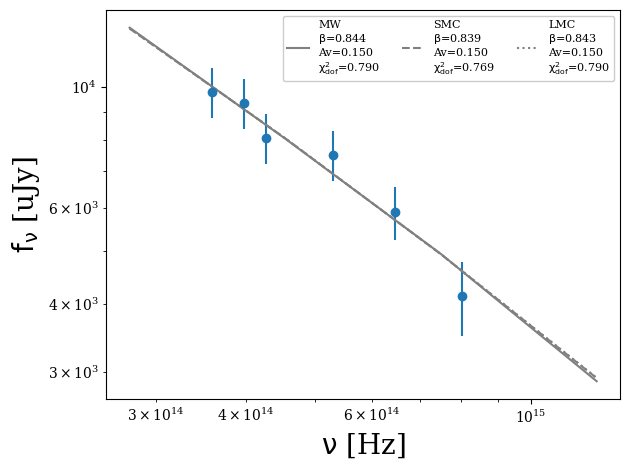

In [105]:
# z = 1.0
z = 0.151
# z = 0.00001

indx_sort = np.argsort(nu)
xdata = np.log(nu[indx_sort]*(1+z))
ydata = np.log(fnu[indx_sort])
sigma = fnuerr[indx_sort]/fnu[indx_sort]

x = np.arange(33.25, 34.5+0.5, 0.5)

#	MW
# lnF0, beta, Av
# popt_mw, pcov_mw = curve_fit(func_extc_MW_linear, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True, bounds=([-np.inf, 0.1, -1.5], [+np.inf, +3, +0.6]))
popt_mw, pcov_mw = curve_fit(func_extc_MW_linear, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True,)
r_mw = ydata - func_extc_MW_linear(xdata, *popt_mw)
chisq_dof_mw = sum((r_mw / sigma) ** 2)/(3-1)

#	SMC
popt_smc, pcov_smc = curve_fit(func_extc_SMC_linear, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True)
r_smc = ydata - func_extc_SMC_linear(xdata, *popt_smc)
chisq_dof_smc = sum((r_smc / sigma) ** 2)/(3-1)

#	LMC
popt_lmc, pcov_lmc = curve_fit(func_extc_LMC_linear, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True)
r_lmc = ydata - func_extc_MW_linear(xdata, *popt_lmc)
chisq_dof_lmc = sum((r_lmc / sigma) ** 2)/(3-1)

plt.errorbar(np.exp(xdata), np.exp(ydata), yerr=fnuerr[indx_sort], marker='o', ls='none',)

#	Av Fix
plt.plot(np.exp(x), np.exp(func_extc_MW_linear(x, *popt_mw)), c='grey', ls='-', label='MW\n'+r'$\rm \beta$'+f'={popt_mw[1]:1.3f}\nAv={0.15:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_mw:1.3f}')
plt.plot(np.exp(x), np.exp(func_extc_SMC_linear(x, *popt_smc)), c='grey', ls='--', label='SMC\n'+r'$\rm \beta$'+f'={popt_smc[1]:1.3f}\nAv={0.15:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_smc:1.3f}')
plt.plot(np.exp(x), np.exp(func_extc_LMC_linear(x, *popt_lmc)), c='grey', ls=':', label='LMC\n'+r'$\rm \beta$'+f'={popt_lmc[1]:1.3f}\nAv={0.15:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_lmc:1.3f}')

#	Av no fix
# plt.plot(np.exp(x), np.exp(func_extc_MW_linear(x, *popt_mw)), c='grey', ls='-', label='MW\n'+r'$\rm \beta$'+f'={popt_mw[1]:1.3f}\nAv={popt_mw[2]:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_mw:1.3f}')
# plt.plot(np.exp(x), np.exp(func_extc_SMC_linear(x, *popt_smc)), c='grey', ls='--', label='SMC\n'+r'$\rm \beta$'+f'={popt_smc[1]:1.3f}\nAv={popt_smc[2]:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_smc:1.3f}')
# plt.plot(np.exp(x), np.exp(func_extc_LMC_linear(x, *popt_lmc)), c='grey', ls=':', label='LMC\n'+r'$\rm \beta$'+f'={popt_lmc[1]:1.3f}\nAv={popt_lmc[2]:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_lmc:1.3f}')

# plt.plot(np.exp(xdata), np.exp(func_extc_MW_linear(xdata, *popt_mw)), c='grey', ls='-', label='MW\n'+r'$\rm \beta$'+f'={popt_mw[1]:1.3f}\nAv={popt_mw[2]:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_mw:1.3f}')
# plt.plot(np.exp(xdata), np.exp(func_extc_SMC_linear(xdata, *popt_smc)), c='grey', ls='--', label='SMC\n'+r'$\rm \beta$'+f'={popt_smc[1]:1.3f}\nAv={popt_smc[2]:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_smc:1.3f}')
# plt.plot(np.exp(xdata), np.exp(func_extc_LMC_linear(xdata, *popt_lmc)), c='grey', ls=':', label='LMC\n'+r'$\rm \beta$'+f'={popt_lmc[1]:1.3f}\nAv={popt_lmc[2]:1.3f}\n'+r'$\rm \chi^{2}_{dof}$='+f'{chisq_dof_lmc:1.3f}')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\rm \nu$ [Hz]')
plt.ylabel(r'$\rm f_{\nu}$'+' [uJy]')
plt.legend(fontsize=8, framealpha=1.0, ncol=3)
plt.tight_layout()
# plt.grid('both', ls='--', c='silver')
plt.tight_layout()